In [ ]:
# Info on how to get your api key (kaggle.json) here: https://github.com/Kaggle/kaggle-api#api-credentials
# Valeria Quiroz  - Gabriel Zapata
%%time
!pip install kaggle
api_token = {"username":"gabrielzapata","key":"45d11139cb4e32995898eae373213b5f"}
import json
import zipfile
import os
with open('/content/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!mkdir /root/.kaggle      
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v/content
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c ga-customer-revenue-prediction
if not os.path.exists("/content/competitions/ga-customer-revenue-prediction"):
    os.makedirs("/content/competitions/ga-customer-revenue-prediction")
os.chdir('/content/competitions/ga-customer-revenue-prediction')
for file in os.listdir():
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

- path is now set to: /content
 93% 57.0M/61.1M [00:01<00:00, 34.1MB/s]
100% 61.1M/61.1M [00:01<00:00, 48.7MB/s]
  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 83.8MB/s]
 83% 47.0M/56.8M [00:01<00:00, 20.3MB/s]
100% 56.8M/56.8M [00:01<00:00, 38.0MB/s]
 98% 328M/333M [00:05<00:00, 52.6MB/s]
100% 333M/333M [00:05<00:00, 60.5MB/s]
 99% 1.10G/1.11G [00:20<00:00, 42.4MB/s]
100% 1.11G/1.11G [00:20<00:00, 58.3MB/s]
 96% 5.00M/5.23M [00:00<00:00, 17.7MB/s]
100% 5.23M/5.23M [00:00<00:00, 17.4MB/s]
CPU times: user 1min 42s, sys: 32.1 s, total: 2min 14s
Wall time: 7min 55s


### **Librerias**

In [ ]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); init.get_weblink() 

replicating local resources


In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from pandas import json_normalize
import seaborn as sns 
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb
import plotly.graph_objs as go
from plotly import subplots
import plotly.offline as py
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import datetime
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold,KFold,RepeatedKFold
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, RepeatVector, TimeDistributed, LSTM, GRU
import numpy as np
import tensorflow as tf,keras    
from tensorflow.keras.models import Sequential  

#from sklearn.metrics import mean_absolute_percentage_error

In [3]:
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, RepeatVector, TimeDistributed, LSTM, GRU
import numpy as np
import tensorflow as tf,keras    
from tensorflow.keras.models import Sequential

In [ ]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

setting tensorflow version in colab


'2.4.1'

### **Explicacion del codigo json sacado de Kaggle, para aplanar los datos**

In [ ]:
def load_df(csv_path='/content/competitions/ga-customer-revenue-prediction/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [ ]:
%%time
train_df = load_df()
#test_df = load_df('/content/competitions/ga-customer-revenue-prediction/test.csv')

Loaded train.csv. Shape: (903653, 55)
CPU times: user 1min 58s, sys: 9.92 s, total: 2min 8s
Wall time: 2min 8s


In [ ]:
train_df = train_df.drop( ['sessionId'] + ["trafficSource.campaignCode"], axis=1)
print(train_df.shape)

(903653, 53)


### **Eliminemos columnas constantes e imputar valores cero a NAN**

In [ ]:
print ("Antes de eliminar columnas constantes - shape de train y test datasets: ", train_df.shape)
train_df = train_df.loc[:, (train_df != train_df.iloc[0]).any()]
print ("Despues de eliminar columnas constantes - shape de train y test datasets: ", train_df.shape)

Antes de eliminar columnas constantes - shape de train y test datasets:  (903653, 53)
Despues de eliminar columnas constantes - shape de train y test datasets:  (903653, 34)


In [ ]:
# Replace NaN values throughout train dataset
train_df.replace(to_replace=np.nan, value=0, inplace=True)

### **Conversion variable categórica a númerica**

In [ ]:
# etiqueta codifica las variables categóricas y convierte las variables numéricas flotantes
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", "device.isMobile",
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    


num_cols = ["totals.hits", "totals.pageviews", "visitNumber", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
   

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
device.isMobile
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


In [ ]:
#######Debido a que las neuronas se sobreajustan por valores tan altos codificamos ######
lbl1=preprocessing.LabelEncoder()
train_df['fullVisitorId']=lbl1.fit_transform(list(train_df['fullVisitorId'].values.astype('str')))
#lbl1.classes_
###lbl1.inverse_transform(train_df['fullVisitorId'])#por si se desea codificar valores originales

In [ ]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent
0,4,20160902,80509,1472830385,1.0,1472830385,11,16,0,0,3,21,204,150,0,258,24932,1.0,1.0,1.0,1.0,0,0,149,5,11,0,1475,0,0,0,0,0,0
1,4,20160902,269007,1472880147,1.0,1472880147,16,7,0,0,5,1,12,375,93,648,6673,1.0,1.0,1.0,1.0,0,0,149,5,11,0,1475,0,0,0,0,0,0
2,4,20160902,277678,1472865386,1.0,1472865386,11,16,0,0,4,19,181,78,0,325,25841,1.0,1.0,1.0,1.0,0,0,149,5,11,0,1475,0,0,0,0,0,0
3,4,20160902,339713,1472881213,1.0,1472881213,46,6,0,0,3,16,94,375,93,648,25841,1.0,1.0,1.0,1.0,0,0,149,5,1099,0,1475,0,0,0,0,0,0
4,4,20160902,194517,1472822600,2.0,1472822600,11,1,1,1,4,13,211,375,93,648,25841,1.0,1.0,1.0,0.0,0,0,149,5,11,1,1475,0,0,0,0,0,0


In [ ]:
train_df.to_csv('dataset.csv')

In [ ]:
train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))###Cambia el formato de la fecha

In [ ]:
Y = train_df["totals.transactionRevenue"].astype('float')
X=train_df.drop(["totals.transactionRevenue"],axis=1)##Eliminamos la salida de los datos de las caracteristicas


In [ ]:
##==================###Fold1######============================
Fold1 = train_df[train_df['date']<=datetime.date(2016,11,1)]
train1=Fold1[Fold1['date']<=datetime.date(2016,9,15)]
Val1=Fold1[Fold1['date']>datetime.date(2016,9,15)]

##==================###Fold2######============================
Foldt = train_df[train_df['date']>datetime.date(2016,11,1)]
Fold2 = Foldt[Foldt['date']<=datetime.date(2017,2,1)]
train2=Fold2[Fold2['date']<=datetime.date(2016,12,15)]
Val2=Fold2[Fold2['date']>datetime.date(2016,12,15)]

##==================###Fold3######============================
Foldt2 = train_df[train_df['date']>datetime.date(2017,2,1)]
Fold3 = Foldt2[Foldt2['date']<=datetime.date(2017,5,1)]
train3=Fold3[Fold3['date']<=datetime.date(2017,3,15)]
Val3=Fold3[Fold3['date']>datetime.date(2017,3,15)]

##===================#####All Train#######====================
X_Train=train_df[train_df['date']<=datetime.date(2017,5,1)]
Y_Train=np.log1p(X_Train["totals.transactionRevenue"].astype('float'))

##======================####Test#####==========================
Test = train_df[train_df['date']>datetime.date(2017,5,1)]
y_test= np.log1p(Test["totals.transactionRevenue"].astype('float'))
X_test=Test.drop(["totals.transactionRevenue"],axis=1)

In [ ]:
dev_y1 = np.log1p(train1["totals.transactionRevenue"].astype('float'))
val_y1 = np.log1p(Val1["totals.transactionRevenue"].astype('float'))
dev_y2 = np.log1p(train2["totals.transactionRevenue"].astype('float'))
val_y2 = np.log1p(Val2["totals.transactionRevenue"].astype('float'))
dev_y3 = np.log1p(train3["totals.transactionRevenue"].astype('float'))
val_y3 = np.log1p(Val3["totals.transactionRevenue"].astype('float'))

In [ ]:
X_Train=X_Train.drop(["totals.transactionRevenue"],axis=1)
train1=train1.drop(["totals.transactionRevenue"],axis=1)
train2=train2.drop(["totals.transactionRevenue"],axis=1)
train3=train3.drop(["totals.transactionRevenue"],axis=1)
Val1=Val1.drop(["totals.transactionRevenue"],axis=1)
Val2=Val2.drop(["totals.transactionRevenue"],axis=1)
Val3=Val3.drop(["totals.transactionRevenue"],axis=1)

In [ ]:
X_Train=X_Train.drop(["date"],axis=1)
train1=train1.drop(["date"],axis=1)
train2=train2.drop(["date"],axis=1)
train3=train3.drop(["date"],axis=1)
Val1=Val1.drop(["date"],axis=1)
Val2=Val2.drop(["date"],axis=1)
Val3=Val3.drop(["date"],axis=1)
X_test=X_test.drop(["date"],axis=1)

In [ ]:
N_TRAIN = train1.shape[0]
BATCH_SIZE = 256
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [9]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=500*1000,
  decay_rate=1,
  staircase=False)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

In [10]:
def model1(Neuronas=32 ,dropout=0.1 ,Acti='relu'):
    model = Sequential()
    model.add(Dense(Neuronas, input_dim=32, activation='relu'))
    model.add(Dense(Neuronas/2, activation=Acti))
    model.add(Dense(Neuronas/8, activation=Acti))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation = 'linear'))
    rmse=tf.keras.metrics.RootMeanSquaredError()
    mae=tf.keras.metrics.MeanAbsoluteError()
    opt=keras.optimizers.Adam(lr_schedule)
    model.compile(optimizer= opt , loss= 'mse', metrics=[ rmse , mae ] )
    return model

In [5]:
def get_callbacks():
  return [
    tf.keras.callbacks.EarlyStopping( monitor = 'loss', patience = 5)
  ]

In [ ]:
num_cell=[ 64 , 128 , 256 , 512 , 1024]  

Drop=[ 0.1 , 0.2 , 0.3 , 0.4 , 0.5 ]   
 

EstimadoresError1=[]

for drop in Drop:
     for num in num_cell:
              model1( num , drop  )
              estimator = KerasRegressor ( build_fn = model1 , batch_size = BATCH_SIZE ,epochs = STEPS_PER_EPOCH  )
              HistoryTrain1=estimator.fit(train1, dev_y1,  verbose = 0 , callbacks=get_callbacks(), validation_data=(Val1, val_y1) ) 
              pred_val_y1 = estimator.predict(Val1)
              RMSE=np.sqrt(metrics.mean_squared_error(val_y1,pred_val_y1))
              MAE=metrics.mean_absolute_error(val_y1,pred_val_y1)
              EstimadoresError1.append([drop,num,RMSE,MAE])
              #print([drop,num,RMSE,MAE])

In [ ]:
EstimadoresError2=[]
for drop in Drop:
     for num in num_cell:
              model1( num , drop  )
              estimator = KerasRegressor ( build_fn = model1 , batch_size = BATCH_SIZE ,epochs = STEPS_PER_EPOCH  )
              HistoryTrain2=estimator.fit(train2, dev_y2,  verbose = 0 , callbacks=get_callbacks()) 
              pred_val_y2 = estimator.predict(Val2)
              RMSE=np.sqrt(metrics.mean_squared_error(val_y2,pred_val_y2))
              MAE=metrics.mean_absolute_error(val_y2,pred_val_y2)
              EstimadoresError2.append([drop,num,RMSE,MAE])

In [ ]:
EstimadoresError3=[]
for drop in Drop:
     for num in num_cell:
              model1( num , drop  )
              estimator = KerasRegressor ( build_fn = model1 , batch_size = BATCH_SIZE ,epochs = STEPS_PER_EPOCH   )
              HistoryTrain3=estimator.fit(train3, dev_y3,  verbose = 0 , callbacks=get_callbacks()) 
              pred_val_y3 = estimator.predict(Val3)
              RMSE=np.sqrt(metrics.mean_squared_error(val_y3,pred_val_y3))
              MAE=metrics.mean_absolute_error(val_y3,pred_val_y3)
              EstimadoresError3.append([drop,num,RMSE,MAE])

In [ ]:
dfEstimadoresError=pd.DataFrame({'Modelo1' :EstimadoresError1,'Modelo2' :EstimadoresError2,'Modelo3' :EstimadoresError3})

In [ ]:
dfEstimadoresError.to_csv('EstimadoresError.csv')

In [ ]:
RMSE1=[]
MAE1=[]
drop=[]
num=[]
l=1
m=1
for i in range(len(EstimadoresError1)):
    mse=(EstimadoresError1[i][2]+EstimadoresError2[i][2]+EstimadoresError3[i][2])/3
    mae=(EstimadoresError1[i][3]+EstimadoresError2[i][3]+EstimadoresError3[i][3])/3
    RMSE1.append(mse)
    MAE1.append(mae)
    drop.append(EstimadoresError1[i][0])
    num.append(EstimadoresError1[i][1])

In [ ]:
Totaldf1EstimadoresError=pd.DataFrame({'drop': drop,'num_cell':num,'RMSE1' :RMSE1,'MAE1' :MAE1,})

In [ ]:
Totaldf1EstimadoresError.to_csv('TotalEstimadoresError.csv')

In [ ]:
Totaldf1EstimadoresError[Totaldf1EstimadoresError['MAE1']==Totaldf1EstimadoresError['MAE1'].min()]

,drop,num_cell,RMSE1,MAE1
0,0.1,64,1.961929,0.230566


In [ ]:
bestMAE=Totaldf1EstimadoresError[Totaldf1EstimadoresError['MAE1']==Totaldf1EstimadoresError['MAE1'].min()]

In [ ]:
bestMAE=np.array(bestMAE)

In [ ]:
Totaldf1EstimadoresError[Totaldf1EstimadoresError['RMSE1']==Totaldf1EstimadoresError['RMSE1'].min()]

,drop,num_cell,RMSE1,MAE1
11,0.3,128,1.950115,0.431064


In [ ]:
bestRMSE=Totaldf1EstimadoresError[Totaldf1EstimadoresError['RMSE1']==Totaldf1EstimadoresError['RMSE1'].min()]

In [ ]:
bestRMSE=np.array(bestRMSE)

los mejores parametros calculados para el menor MAE

In [12]:
esquema=model1(64,0.1)

In [13]:
esquema.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 264       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 4,465
Trainable params: 4,465
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1( bestMAE[0][1],bestMAE[0][0] )
bestestimator = KerasRegressor ( build_fn = model1 , batch_size = BATCH_SIZE ,epochs = STEPS_PER_EPOCH   )

In [ ]:
HistoryTrain=bestestimator.fit(X_Train, Y_Train,  verbose = 0 , callbacks=get_callbacks(),validation_data=(X_test,y_test))

In [ ]:
pred_test_y = bestestimator.predict(X_test)

In [ ]:
#####ERROR POR REGI#########
print(f"RMSE= {np.sqrt(metrics.mean_squared_error(y_test,pred_test_y))}")
print(f"MAE= {metrics.mean_absolute_error(y_test,pred_test_y)}")

RMSE= 2.177117234091053
MAE= 0.48892832869077385


In [ ]:
######ERROR POR USUARIO
test_pred_df = pd.DataFrame({"fullVisitorId":X_test["fullVisitorId"].values})
test_pred_df["transactionRevenue"] =(y_test.values)
test_pred_df["PredictedRevenue"] = (pred_test_y)
test_pred_df = test_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print('RMSE')
print(np.sqrt(metrics.mean_squared_error(test_pred_df["transactionRevenue"].values, test_pred_df["PredictedRevenue"].values)))
print('MAE')
print((metrics.mean_absolute_error(test_pred_df["transactionRevenue"].values, test_pred_df["PredictedRevenue"].values)))

RMSE
2.7337885062801868
MAE
0.607499326729506


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



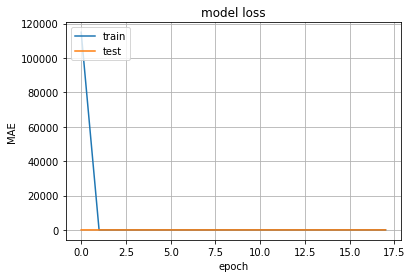

In [ ]:
loss=HistoryTrain.history['mean_absolute_error']
test_rmse=HistoryTrain.history['val_mean_absolute_error']
plt.plot(loss)
plt.plot(test_rmse)
plt.title('model loss')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

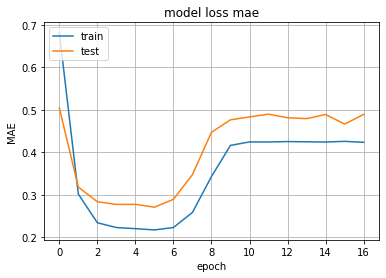

In [ ]:
loss=HistoryTrain.history['mean_absolute_error']
test_rmse=HistoryTrain.history['val_mean_absolute_error']
plt.plot(loss[1:])
plt.plot(test_rmse[1:])
plt.title('model loss mae')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

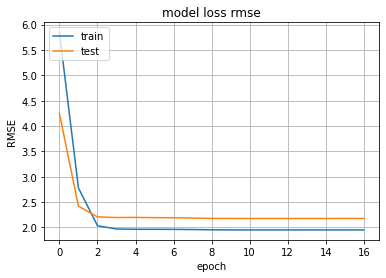

In [ ]:
loss=HistoryTrain.history['root_mean_squared_error']
test_rmse=HistoryTrain.history['val_root_mean_squared_error']
plt.plot(loss[1:])
plt.plot(test_rmse[1:])
plt.title('model loss rmse')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

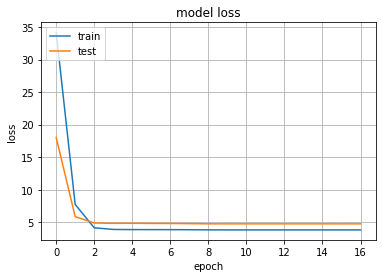

In [ ]:
loss=HistoryTrain.history['loss']
test_rmse=HistoryTrain.history['val_loss']
plt.plot(loss[1:])
plt.plot(test_rmse[1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

Error de entrenamiento MAE

In [ ]:
pred_train1_y = bestestimator.predict(train1)
pred_train2_y = bestestimator.predict(train2)
pred_train3_y = bestestimator.predict(train3)

In [ ]:
###ERROR POR REGISTRO#########################
MAEfold1=metrics.mean_absolute_error(dev_y1,pred_train1_y)
MAEfold2=metrics.mean_absolute_error(dev_y2,pred_train2_y)
MAEfold3=metrics.mean_absolute_error(dev_y3,pred_train3_y)
ERROREntremamientaMAE=(MAEfold1+MAEfold2+MAEfold3)/3
print('MAEerrorTrain')
print(ERROREntremamientaMAE)

MAEerrorTrain
0.4399793222491486


In [ ]:
######ERROR POR USUARIO#######################
train1_pred_df = pd.DataFrame({"fullVisitorId":train1["fullVisitorId"].values})
train1_pred_df["transactionRevenue"] =(dev_y1.values)
train1_pred_df["PredictedRevenue"] = (pred_train1_y)
train1_pred_df = train1_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()

train2_pred_df = pd.DataFrame({"fullVisitorId":train2["fullVisitorId"].values})
train2_pred_df["transactionRevenue"] =(dev_y2.values)
train2_pred_df["PredictedRevenue"] = (pred_train2_y)
train2_pred_df = train2_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()

train3_pred_df = pd.DataFrame({"fullVisitorId":train3["fullVisitorId"].values})
train3_pred_df["transactionRevenue"] =(dev_y3.values)
train3_pred_df["PredictedRevenue"] = (pred_train3_y)
train3_pred_df = train3_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()


MAEfold1U=metrics.mean_absolute_error(train1_pred_df["transactionRevenue"].values, train1_pred_df["PredictedRevenue"].values)
MAEfold2U=metrics.mean_absolute_error(train2_pred_df["transactionRevenue"].values, train2_pred_df["PredictedRevenue"].values)
MAEfold3U=metrics.mean_absolute_error(train3_pred_df["transactionRevenue"].values, train3_pred_df["PredictedRevenue"].values)

ERROREntremamientaMAEU=(MAEfold1U+MAEfold2U+MAEfold3U)/3
print('MAEerrorTrainU')
print(ERROREntremamientaMAEU)

MAEerrorTrainU
0.5213459339560772


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Error de Validacion MAE

In [ ]:
pred_val1_y = bestestimator.predict(Val1)
pred_val2_y = bestestimator.predict(Val2)
pred_val3_y = bestestimator.predict(Val3)

In [ ]:
MAEfoldV1=metrics.mean_absolute_error(val_y1,pred_val1_y)
MAEfoldV2=metrics.mean_absolute_error(val_y2,pred_val2_y)
MAEfoldV3=metrics.mean_absolute_error(val_y3,pred_val3_y)
ERRORValidacionMAEV=(MAEfoldV1+MAEfoldV2+MAEfoldV3)/3
print('MAEerrorVal')
print(ERRORValidacionMAEV)

MAEerrorVal
0.4362359168643643


In [ ]:
######ERROR POR USUARIO#######################
Val1_pred_df = pd.DataFrame({"fullVisitorId":Val1["fullVisitorId"].values})
Val1_pred_df["transactionRevenue"] =(val_y1.values)
Val1_pred_df["PredictedRevenue"] = (pred_val1_y)
Val1_pred_df = Val1_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()

Val2_pred_df = pd.DataFrame({"fullVisitorId":Val2["fullVisitorId"].values})
Val2_pred_df["transactionRevenue"] =(val_y2.values)
Val2_pred_df["PredictedRevenue"] = (pred_val2_y)
Val2_pred_df = Val2_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()

Val3_pred_df = pd.DataFrame({"fullVisitorId":Val3["fullVisitorId"].values})
Val3_pred_df["transactionRevenue"] =(val_y3.values)
Val3_pred_df["PredictedRevenue"] = (pred_val3_y)
Val3_pred_df = Val3_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()

MAEfold1UV=metrics.mean_absolute_error(Val1_pred_df["transactionRevenue"].values, Val1_pred_df["PredictedRevenue"].values)
MAEfold2UV=metrics.mean_absolute_error(Val2_pred_df["transactionRevenue"].values, Val2_pred_df["PredictedRevenue"].values)
MAEfold3UV=metrics.mean_absolute_error(Val3_pred_df["transactionRevenue"].values, Val3_pred_df["PredictedRevenue"].values)

ERRORValidacionMAEU=(MAEfold1UV+MAEfold2UV+MAEfold3UV)/3
print('MAEerrorValU')
print(ERRORValidacionMAEU)

MAEerrorValU
0.5212058267686678


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



los mejores parametros calculados para el menor MSE

In [14]:
esquema1=model1(128,0.3)

In [15]:
esquema1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 13,537
Trainable params: 13,537
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1( bestRMSE[0][1] , bestRMSE[0][0] )
bestestimator1 = KerasRegressor ( build_fn = model1 , batch_size = BATCH_SIZE ,epochs = STEPS_PER_EPOCH )

In [ ]:
HistoryTrainMSE=bestestimator1.fit(X_Train, Y_Train,  verbose = 0 ,callbacks=get_callbacks(),validation_data=(X_test,y_test))

In [ ]:
pred_test_yMSE = bestestimator1.predict(X_test)

In [ ]:
#####ERROR POR REGI#########
print(f"RMSE= {np.sqrt(metrics.mean_squared_error(y_test,pred_test_yMSE))}")
print(f"MAE= {metrics.mean_absolute_error(y_test,pred_test_yMSE)}")

RMSE= 2.177320120159659
MAE= 0.4801686784906767


In [ ]:
######ERROR POR USUARIO
test_pred_df = pd.DataFrame({"fullVisitorId":X_test["fullVisitorId"].values})
test_pred_df["transactionRevenue"] =(y_test.values)
test_pred_df["PredictedRevenue"] = (pred_test_yMSE)
test_pred_df = test_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print('RMSE')
print(np.sqrt(metrics.mean_squared_error(test_pred_df["transactionRevenue"].values, test_pred_df["PredictedRevenue"].values)))
print('MAE')
print((metrics.mean_absolute_error(test_pred_df["transactionRevenue"].values, test_pred_df["PredictedRevenue"].values)))

RMSE
2.735800917154242
MAE
0.596945821975166


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



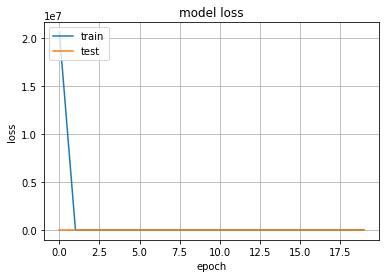

In [ ]:
loss=HistoryTrainMSE.history['root_mean_squared_error']
test_rmse=HistoryTrainMSE.history['val_root_mean_squared_error']
plt.plot(loss)
plt.plot(test_rmse)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

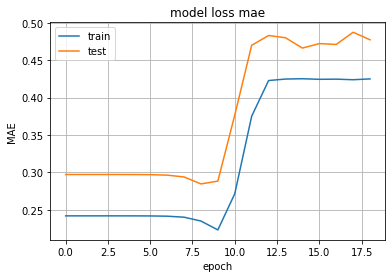

In [ ]:
loss=HistoryTrainMSE.history['mean_absolute_error']
test_rmse=HistoryTrainMSE.history['val_mean_absolute_error']
plt.plot(loss[1:])
plt.plot(test_rmse[1:])
plt.title('model loss mae')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

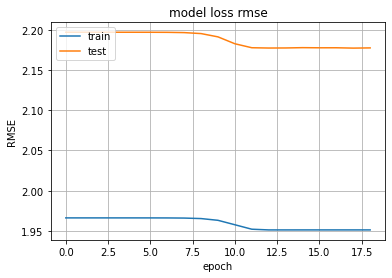

In [ ]:
loss=HistoryTrainMSE.history['root_mean_squared_error']
test_rmse=HistoryTrainMSE.history['val_root_mean_squared_error']
plt.plot(loss[1:])
plt.plot(test_rmse[1:])
plt.title('model loss rmse')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

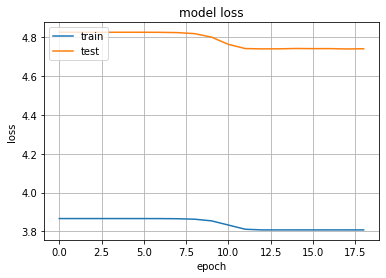

In [ ]:
loss=HistoryTrainMSE.history['loss']
test_rmse=HistoryTrainMSE.history['val_loss']
plt.plot(loss[1:])
plt.plot(test_rmse[1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

Error de entrenamiento MSE

In [ ]:
pred_train1a_y = bestestimator1.predict(train1)
pred_train2a_y = bestestimator1.predict(train2)
pred_train3a_y = bestestimator1.predict(train3)

In [ ]:
###ERROR POR REGISTRO#########################
RMSEfold1=np.sqrt(metrics.mean_squared_error(dev_y1,pred_train1a_y))
RMSEfold2=np.sqrt(metrics.mean_squared_error(dev_y2,pred_train2a_y))
RMSEfold3=np.sqrt(metrics.mean_squared_error(dev_y3,pred_train3a_y))
ERROREntremamientaRMSE=(RMSEfold1+RMSEfold2+RMSEfold3)/3
print('RMSEerrorTrain')
print(ERROREntremamientaRMSE)

RMSEerrorTrain
1.9724052923596014


In [ ]:
######ERROR POR USUARIO#######################
train1a_pred_df = pd.DataFrame({"fullVisitorId":train1["fullVisitorId"].values})
train1a_pred_df["transactionRevenue"] =(dev_y1.values)
train1a_pred_df["PredictedRevenue"] = (pred_train1a_y)
train1a_pred_df = train1a_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()

train2a_pred_df = pd.DataFrame({"fullVisitorId":train2["fullVisitorId"].values})
train2a_pred_df["transactionRevenue"] =(dev_y2.values)
train2a_pred_df["PredictedRevenue"] = (pred_train2a_y)
train2a_pred_df = train2a_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()

train3a_pred_df = pd.DataFrame({"fullVisitorId":train3["fullVisitorId"].values})
train3a_pred_df["transactionRevenue"] =(dev_y3.values)
train3a_pred_df["PredictedRevenue"] = (pred_train3a_y)
train3a_pred_df = train3a_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()


RMSEfold1UT=np.sqrt(metrics.mean_squared_error(train1a_pred_df["transactionRevenue"].values, train1a_pred_df["PredictedRevenue"].values))
RMSEfold2UT=np.sqrt(metrics.mean_squared_error(train2a_pred_df["transactionRevenue"].values, train2a_pred_df["PredictedRevenue"].values))
RMSEfold3UT=np.sqrt(metrics.mean_squared_error(train3a_pred_df["transactionRevenue"].values, train3a_pred_df["PredictedRevenue"].values))

ERROREntrenamientoRMSEU=(RMSEfold1UT+RMSEfold2UT+RMSEfold3UT)/3
print('RMSEerrorTrainU')
print(ERROREntrenamientoRMSEU)

RMSEerrorTrainU
2.403720629865442


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Error de Validacion

In [ ]:
pred_val1a_y = bestestimator1.predict(Val1)
pred_val2a_y = bestestimator1.predict(Val2)
pred_val3a_y = bestestimator1.predict(Val3)

In [ ]:
###ERROR POR REGISTRO#########################
RMSEfoldV1=np.sqrt(metrics.mean_squared_error(val_y1,pred_val1a_y))
RMSEfoldV2=np.sqrt(metrics.mean_squared_error(val_y2,pred_val2a_y))
RMSEfoldV3=np.sqrt(metrics.mean_squared_error(val_y3,pred_val3_y))
ERRORValidacionRMSEV=(RMSEfoldV1+RMSEfoldV2+RMSEfoldV3)/3
print('RMSEerrorVal')
print(ERRORValidacionRMSEV)

RMSEerrorVal
1.9497232913616396


In [ ]:
######ERROR POR USUARIO#######################
Val1a_pred_df = pd.DataFrame({"fullVisitorId":Val1["fullVisitorId"].values})
Val1a_pred_df["transactionRevenue"] =(val_y1.values)
Val1a_pred_df["PredictedRevenue"] = (pred_val1a_y)
Val1a_pred_df = Val1a_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()

Val2a_pred_df = pd.DataFrame({"fullVisitorId":Val2["fullVisitorId"].values})
Val2a_pred_df["transactionRevenue"] =(val_y2.values)
Val2a_pred_df["PredictedRevenue"] = (pred_val2a_y)
Val2a_pred_df = Val2a_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()

Val3a_pred_df = pd.DataFrame({"fullVisitorId":Val3["fullVisitorId"].values})
Val3a_pred_df["transactionRevenue"] =(val_y3.values)
Val3a_pred_df["PredictedRevenue"] = (pred_val3_y)
Val3a_pred_df = Val3a_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()


RMSEfold1UV=np.sqrt(metrics.mean_squared_error(Val1a_pred_df["transactionRevenue"].values, Val1a_pred_df["PredictedRevenue"].values))
RMSEfold2UV=np.sqrt(metrics.mean_squared_error(Val2a_pred_df["transactionRevenue"].values, Val2a_pred_df["PredictedRevenue"].values))
RMSEfold3UV=np.sqrt(metrics.mean_squared_error(Val3a_pred_df["transactionRevenue"].values, Val3a_pred_df["PredictedRevenue"].values))

ERRORValidacionRMSEU=(RMSEfold1UV+RMSEfold2UV+RMSEfold3UV)/3
print('RMSEerrorValU')
print(ERRORValidacionRMSEU)

RMSEerrorValU
2.3614851235595746


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

